In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
from datetime import datetime
import json
import requests

In [2]:
def toUnixTime(date,form):
    t2 = datetime.strptime(date, form)
    t1 = datetime(1970, 1, 1)
    ans = (t2 - t1).total_seconds()*1000
    ans = int(ans)
    return ans

In [3]:
sources = {}
data = {}

In [4]:
url = lambda metric: f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{metric}_global.csv' 
metrics = ['confirmed', 'recovered', 'deaths'] 
for metric in metrics: sources[metric] = url(metric)
time_series = {metric: pd.read_csv(sources[metric]) for metric in metrics}

for metric in time_series:
    df = time_series[metric]
    gb = df.groupby('Country/Region')
    df = gb.sum()
    df = df.loc[:,'1/22/20':] 
    time_series[metric] = df

In [5]:
time_series['infected'] = time_series['confirmed']-time_series['recovered']-time_series['deaths']

In [6]:
for metric in metrics:
    time_series[metric].loc['World'] = time_series[metric].sum()
    time_series[f'daily_{metric}'] = time_series[metric].diff(axis=1)
    time_series[f'7MA_daily_{metric}'] = time_series[f'daily_{metric}'].rolling(window=7, axis=1).mean()

In [7]:
sources['iso'] = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
iso = pd.read_csv(sources['iso'], index_col='name')
rename = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "Iran (Islamic Republic of)": "Iran",
    "Korea, Republic of": "Korea, South",
    "Taiwan, Province of China": "Taiwan*",
    "United States of America": "US",
    "Russian Federation":"Russia",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "Moldova, Republic of": "Moldova",
    "Viet Nam": "Vietnam",
    "Tanzania, United Republic of": "Tanzania",
    "Palestine, State of": "West Bank and Gaza",
    "Syrian Arab Republic": "Syria",
    "Lao People's Democratic Republic": "Laos",
    "Myanmar":"Burma",
    "Congo, Democratic Republic of the": "Congo (Kinshasa)",
    "Congo": "Congo (Brazzaville)"
}
iso.rename(index=rename, inplace=True)
iso.loc['Kosovo'] = 'XK'
iso.loc['Namibia'] = 'NA'
iso.loc['World'] = 'WD'

In [8]:
general = pd.DataFrame(index=time_series['confirmed'].index)

for metric in metrics:
    general[metric] = time_series[metric].iloc[:,-1]
    general[f'daily_{metric}'] = time_series[f'daily_{metric}'].iloc[:,-1]

general = general.astype(int)
general.sort_values('confirmed', ascending=False, inplace=True) 
general = general.applymap(lambda x: '{:,}'.format(x))

In [9]:
general['country'] = general.index
general['iso'] = iso['alpha-2']
general['region'] = iso['region']

In [10]:
no_match = general[general['iso'].isnull()].index
for metric in time_series:
    time_series[metric].drop(index=no_match, inplace=True)
general.drop(index=no_match, inplace=True)

In [11]:
class countryData:
    def __init__(self, country):
        self.name = country 
        self.time_series = {metric: time_series[metric].loc[country] for metric in time_series}
        self.general = general.loc[country]
        self.preProcessing()
    
    def preProcessing(self):
        def getStart(atleast=1):
            s = self.time_series['confirmed']
            s = s['1/29/20':]
            s = s[s > atleast]
            if len(s): return s.index[0]
            return getStart(1)
        start = getStart(100)
        general['start'] = start
        self.time_series = {metric: self.time_series[metric][start:] for metric in self.time_series}

    def to_dict(self):
        res = {
            'general': self.general.to_dict(),
            'time_series': {metric: self.time_series[metric].to_list() for metric in self.time_series}
        }
        return res

In [12]:
def genCountryData(country):
    data = countryData(country)
    return data.to_dict()

In [13]:
mx = genCountryData('Mexico')

In [17]:
general

,confirmed,daily_confirmed,recovered,daily_recovered,deaths,daily_deaths,country,iso,region,start
Country/Region,,,,,,,,,,
World,"30,935,011","157,405","21,159,459","142,658","959,565","2,589",World,WD,WD,3/18/20
US,"6,804,814","39,844","2,590,671","13,225","199,509",250,US,US,Americas,3/18/20
India,"5,400,619",0,"4,303,043",0,"86,752",0,India,IN,Asia,3/18/20
Brazil,"4,544,629","16,389","3,963,446","26,553","136,895",363,Brazil,BR,Americas,3/18/20
Russia,"1,098,958","6,043","906,431","2,886","19,349",79,Russia,RU,Europe,3/18/20
...,...,...,...,...,...,...,...,...,...,...
Dominica,24,0,18,0,0,0,Dominica,DM,Americas,3/18/20
Laos,23,0,22,0,0,0,Laos,LA,Asia,3/18/20
Saint Kitts and Nevis,17,0,17,0,0,0,Saint Kitts and Nevis,KN,Americas,3/18/20


In [16]:
for country in ['Mexico', 'US']:
    country_iso = general.loc[country]['iso']
    res = genCountryData(country)
    with open('time_series/'+country_iso+'.json', 'w') as doc:
        json.dump(res, doc)

KeyError: 'MX'

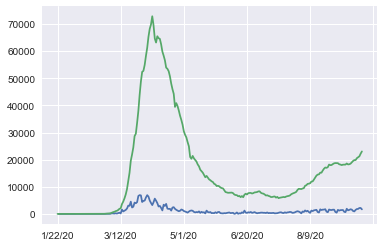

In [59]:
country = 'Germany'
x = time_series['confirmed'].loc[country] - time_series['recovered'].loc[country] - time_series['deaths'].loc[country]
time_series['daily_confirmed'].loc[country].plot()
x.plot()
plt.show()

In [ ]:
for country in general.index.values:
    res = getCountryData(country)
    country_iso = general.loc[country]['iso']
    with open('world/'+country_iso+'.json', 'w') as doc:
            json.dump(res, doc)
    general.to_json('world/general.json', orient='records')